In [1]:
# prompt: mount to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/DL/May2025
!ls

/content/drive/MyDrive/DL/May2025
 BiLSTM.ipynb   DL_CK_01.pdf  'test_02 Cleaned.csv'  'train_02 Cleaned.csv'
 BT_01	        LSTM.ipynb     test_02.csv	      train_02.csv


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
import re
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

def remove_digits(text):
    return re.sub(r'\d', '', text)

import string,time
string.punctuation

exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))


from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

In [5]:
def text_cleaning(text):
    text = remove_html_tags(text)
    text = remove_url(text)
    text = text.lower()
    text = remove_digits(text)
    text = remove_punc(text)
    text = remove_stopwords(text)
    return text

In [6]:
df_train = pd.read_csv("train_02 Cleaned.csv")
df_test = pd.read_csv("test_02 Cleaned.csv")
df_train['Class Index'] = df_train['Class Index'].map({4 : 3, 3: 2, 2: 1, 1 : 0})
df_test['Class Index'] = df_test['Class Index'].map({4 : 3, 3: 2, 2: 1, 1 : 0})

X_train = df_train['Description']
y_train = df_train['Class Index']
X_test = df_test['Description']
y_test = df_test['Class Index']


from collections import Counter

def tokenize(text):
    return word_tokenize(text)

# Xây dựng vocab từ training set
counter = Counter()
for text in X_train:
    counter.update(tokenize(text))

vocab = {'<PAD>': 0, '<UNK>': 1}
for word, freq in counter.items():
    if freq >= 5 and freq <= 8000:
        vocab[word] = len(vocab)

def encode(text, vocab, max_len=30):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab['<UNK>']) for token in tokens[-max_len:]]
    return [vocab['<PAD>']] * (max_len - len(ids)) + ids


In [7]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=30):
        self.texts = texts
        self.labels = labels.values
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode(self.texts.iloc[idx], self.vocab, self.max_len)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

train_dataset = NewsDataset(X_train, y_train, vocab)
test_dataset = NewsDataset(X_test, y_test, vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [15]:
import torch.nn as nn
import torch

class NewsRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, num_layers=1, out_dim=4):
        super(NewsRNN, self).__init__()

        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, out_dim)

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device))

    def forward(self, x, state=None, return_state=False):
        x = self.embedding(x)
        if state is None:
            state = self.init_hidden(x.size(0), x.device)
        out, state = self.lstm(x, state)

        out = self.fc(out[:, -1, :])  # dùng hidden tại bước cuối
        return out if not return_state else (out, state)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NewsRNN(vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

NewsRNN(
  (embedding): Embedding(25233, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [16]:
# prompt: tham số từng lớp

def count_parameters(model):
    """
    Prints the number of trainable parameters for each layer in a PyTorch model.
    """
    print("Trainable parameters per layer:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            print(f"{name}: {num_params}")
            total_params += num_params
    print(f"Total trainable parameters: {total_params}")

count_parameters(model)


Trainable parameters per layer:
embedding.weight: 3229824
lstm.weight_ih_l0: 32768
lstm.weight_hh_l0: 16384
lstm.bias_ih_l0: 256
lstm.bias_hh_l0: 256
lstm.weight_ih_l0_reverse: 32768
lstm.weight_hh_l0_reverse: 16384
lstm.bias_ih_l0_reverse: 256
lstm.bias_hh_l0_reverse: 256
fc.weight: 512
fc.bias: 4
Total trainable parameters: 3329668


In [17]:
def evaluate(model, test_loader, save_wrong_predict=False):
    model.eval()
    correct = 0
    total = 0
    wrong_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            if save_wrong_predict:
                for i in range(labels.size(0)):
                    total += 1
                    if predicted[i] == labels[i]:
                        correct += 1
                    else:
                        wrong_predictions.append({
                            'input': inputs[i].cpu(),        # Chuyển về CPU nếu cần xem
                            'predicted': predicted[i].item(),
                            'label': labels[i].item()
                        })
            else:
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = correct / total
    return accuracy, wrong_predictions

Epoch 1, Loss: 0.5248
Epoch 1, Accuracy: 0.8817
Epoch 2, Loss: 0.2810
Epoch 2, Accuracy: 0.8963
Epoch 3, Loss: 0.2114
Epoch 3, Accuracy: 0.8983
Epoch 4, Loss: 0.1607
Epoch 4, Accuracy: 0.9005
Epoch 5, Loss: 0.1182
Epoch 5, Accuracy: 0.8983
Epoch 6, Loss: 0.0863
Epoch 6, Accuracy: 0.8958
Epoch 7, Loss: 0.0636
Epoch 7, Accuracy: 0.8924
Epoch 8, Loss: 0.0489
Epoch 8, Accuracy: 0.8905
Epoch 9, Loss: 0.0374
Epoch 9, Accuracy: 0.8899
Epoch 10, Loss: 0.0311
Epoch 10, Accuracy: 0.8870


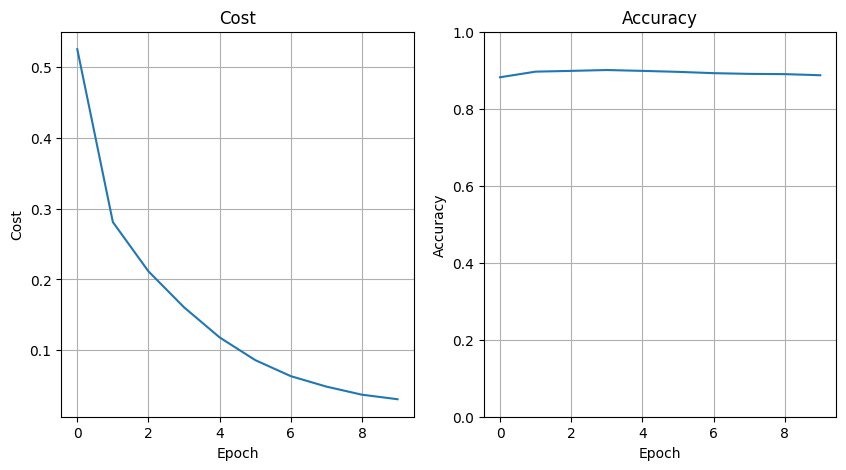

In [18]:
import matplotlib.pyplot as plt
import numpy as np

costs = []
accs = []

# Train loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
    costs.append(total_loss/len(train_loader))
    accuracy, _ = evaluate(model, test_loader)
    accs.append(accuracy)
    print(f"Epoch {epoch+1}, Accuracy: {accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.squeeze(costs))
plt.title('Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.squeeze(accs))
plt.title('Accuracy')
plt.ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
plt.xlabel('Epoch')  # Nếu trục x là số epoch
plt.ylabel('Accuracy')  # Nhãn trục y
plt.grid(True)  # (tùy chọn) giúp dễ đọc hơn
plt.show()


In [19]:
def convert_input(text):
    input_indices = text.tolist()
    # Tạo dictionary ngược từ index về từ
    reverse_vocab = {idx: word for word, idx in vocab.items()}

    # Chuyển các chỉ số về từ
    input_words = [reverse_vocab.get(idx, '<UNK>') for idx in input_indices]

    # Lọc bỏ các token PAD để có câu gốc (hoặc phần cuối câu)
    input_sentence = ' '.join([word for word in input_words if word != '<PAD>'])
    return input_sentence


In [20]:
NewsClass = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Science'}

acc, wrongs = evaluate(model, test_loader, save_wrong_predict=True)
print("Accuracy:", acc)
print("Number of wrong predictions:", len(wrongs))

# In ra 3 dự đoán sai đầu tiên (nếu có)
for i, item in enumerate(wrongs[:10]):
    print(f"\nWrong #{i+1}:")
    # print("Input:", item['input'])
    print("Input Sentence:", convert_input(item['input']))
    print("Predicted:", NewsClass[item['predicted']])
    print("Label:", NewsClass[item['label']])

Accuracy: 0.8869736842105264
Number of wrong predictions: 859

Wrong #1:
Input Sentence: schools <UNK> <UNK> downloading <UNK> <UNK> <UNK> got little wrote open letter <UNK> unfortunately <UNK> <UNK> writing <UNK> representatives hope find useful perhaps feel inspired something similar thing happened area
Predicted: Sports
Label: Science

Wrong #2:
Input Sentence: dolphin groups <UNK> rely <UNK> keep collapsing scientists claim
Predicted: World
Label: Science

Wrong #3:
Input Sentence: life begin one <UNK> clue stems fossil records western australia although whether layered <UNK> biological chemical spawned spirited debate oxford researcher <UNK> <UNK> describes issues contention
Predicted: Business
Label: Science

Wrong #4:
Input Sentence: update earnings per share rise compared year ago company misses analysts expectations long shot
Predicted: Business
Label: Science

Wrong #5:
Input Sentence: michael liedtke san francisco <UNK> low prices <UNK> attitude discount stock broker charles

In [21]:
NewsClass = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Science'}

def predict(text):
    model.eval()
    encoded = torch.tensor([encode(text, vocab)], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(encoded)
        predict = output.argmax().item()
        return NewsClass[predict]

df = pd.read_csv("train_02.csv")
text = df['Description'][1]
print(text)
print(predict(text_cleaning(text)))
print(NewsClass[df['Class Index'][1]-1])


Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Business
Business
